In [1]:
import pandas as pd
from itertools import chain

development = pd.read_csv("./../../DSL_Winter_Project_2024/development.csv")

outlier_column_index=[0, 7, 12, 15, 16, 17]
columns_to_drop=[]

for index in outlier_column_index:
    columns_to_drop.append('pmax[%s]' % index)
    columns_to_drop.append('negpmax[%s]' % index)
    columns_to_drop.append('tmax[%s]' % index)
    columns_to_drop.append('area[%s]' % index)
    columns_to_drop.append('rms[%s]' % index)

df=development.drop(columns=columns_to_drop)

train_datasets = []
test_datasets=[]

for i in range(0, len(df), 100):
    subset1 = df.iloc[i:i+100].head(3)
    train_datasets.append(subset1)

    subset2 = df.iloc[i:i+100].tail(1)
    test_datasets.append(subset2)

train_df=pd.concat(train_datasets, ignore_index=False)
test_df=pd.concat(test_datasets, ignore_index=False)

In [2]:
X_train=train_df.drop(columns=['x', 'y'])
y_train=train_df.loc[:,['x', 'y']]

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=0)
)

regr_multirf.fit(X_train, y_train)
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=30, random_state=2)

In [6]:
X_test=test_df.drop(columns=['x', 'y'])
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

In [7]:
print(y_multirf)
print(y_rf)

[[206.45 206.35]
 [208.   215.65]
 [203.95 232.1 ]
 ...
 [591.95 577.65]
 [592.75 587.7 ]
 [585.85 577.4 ]]
[[205.7  204.  ]
 [210.45 211.  ]
 [205.5  226.15]
 ...
 [596.35 578.15]
 [594.1  590.6 ]
 [592.2  595.  ]]


In [10]:
y_test=test_df.loc[:,['x', 'y']]
y_test

,x,y
99,200.0,200.0
199,200.0,220.0
299,200.0,225.0
399,200.0,230.0
499,200.0,235.0
...,...,...
385099,600.0,575.0
385199,600.0,580.0
385299,600.0,585.0
385399,600.0,590.0


# compare distance

In [20]:
import numpy as np
distance1=np.mean(np.sqrt(np.sum((y_multirf - y_test) ** 2, axis=1)))
distance1

7.2951623010239715

In [21]:
distance2=np.mean(np.sqrt(np.sum((y_rf - y_test) ** 2, axis=1)))
distance2

6.143480493433042

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

regr_rf = RandomForestRegressor(random_state=0)
regr_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [9]:
import numpy as np

X_test=test_df.drop(columns=['x', 'y'])
y_test=test_df.loc[:,['x', 'y']]


y_rf = regr_rf.predict(X_test)
distance=np.mean(np.sqrt(np.sum((y_rf - y_test) ** 2, axis=1)))
distance



6.214035275865451

In [5]:
X_test=test_df.drop(columns=['x', 'y'])
y_test=test_df.loc[:,['x', 'y']]

Mean Squared Error: 13729.727055410698


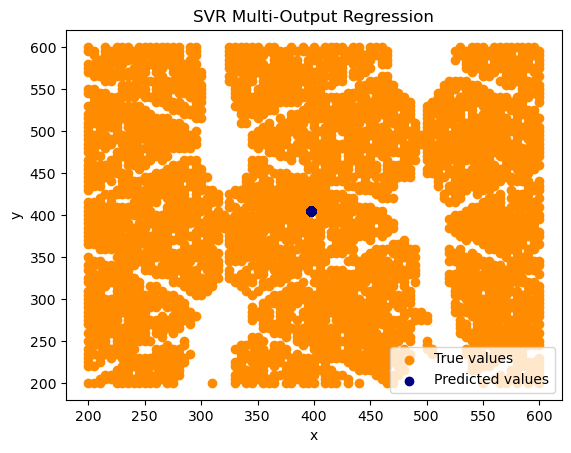

In [6]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 使用 SVR 模型进行多输出回归
svr = MultiOutputRegressor(SVR(kernel='rbf', C=1e3, gamma=0.1))

# 训练模型
svr.fit(X_train, y_train)

# 预测
y_pred = svr.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

# 绘制预测结果
plt.scatter(y_test['x'], y_test['y'], color='darkorange', label='True values')
plt.scatter(y_pred[:, 0], y_pred[:, 1], color='navy', label='Predicted values')
plt.xlabel('x')
plt.ylabel('y')
plt.title('SVR Multi-Output Regression')
plt.legend()
plt.show()


In [8]:
import numpy as np

distance1=np.mean(np.sqrt(np.sum((y_pred - y_test) ** 2, axis=1)))
distance1

154.64133667144276

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

# 定义超参数搜索范围
param_dist = {
    'estimator__C': np.logspace(-3, 3, 7),
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__gamma': np.logspace(-3, 3, 7),
    'estimator__epsilon': np.linspace(0.1, 0.5, 5)
}

svr = SVR()
regressor = MultiOutputRegressor(svr)

random_search = RandomizedSearchCV(regressor, param_distributions=param_dist,
                                   scoring='neg_mean_squared_error', cv=5, n_iter=50, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳模型进行预测
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
